# Simple sound processing via `WCA1`

In [1]:
import Pkg
Pkg.activate("../../WCA1")
using WCA1

 Activating environment at `~/amusements/WCA1/Project.toml`


# STFT of a signal

We construct an artificial signal, composed of two linearly varying frequencies.

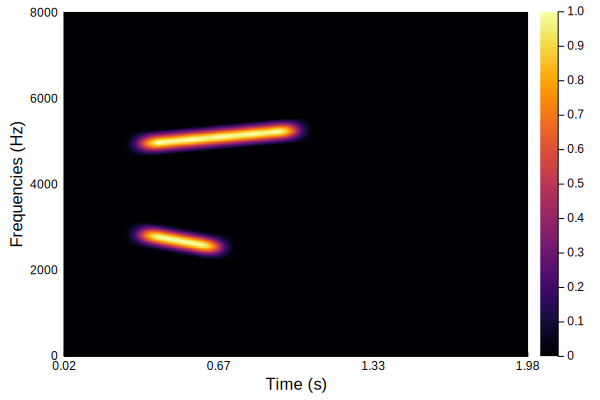

In [2]:
using ImageFiltering

# We just generate an STFT container, starting from a sound
rate = 16000.
duration = 2
samples = round(Int,duration*rate)
y = [ t <= 8*samples/14 ? sin(1000*2*π*t/rate+1000*t/rate*2*π*t/rate) : 0. for t in 1:samples ]

S = stft(y, 500, 450, fs = rate);

function two_bars(p1, p2, km1, km2, N1, N2; λ = 4)
    # the bars
    U0v1=10*[(((i+10)p1+km1-1<j<(i-10)p1+km1+1) && (N2/6<i<N2/2) ) ? 1. : 0. for j in 1:N1, i in 1:N2]
    U0v2=10*[(((i+3)p2+km2-1<j<(i-3)p2+km2+1) && (N2/6<i<N2/3) ) ? 1. : 0. for j in 1:N1, i in 1:N2]

    # a little bit of smoothing
    imfilter!(U0v1, U0v1,ImageFiltering.Kernel.gaussian((λ,3λ)))
    imfilter!(U0v2, U0v2,ImageFiltering.Kernel.gaussian((λ,3λ)))

    # combining them
    U0v1/maximum(U0v1)+U0v2/maximum(U0v2)
end

# wrapping everything up
function two_bars_stft(p1, p2, km1, km2, SS::STFT; args...) 
    U0 = two_bars(p1,p2,km1,km2,  length(SS.freq), length(SS.time); args...)
    STFT(ComplexF64.(U0), SS.freq, SS.time, SS.width)
end

p0 = 1000 .*step(S.time)/step(S.freq)
S = two_bars_stft(p0/2, -p0, 150, 100, S)

show_stft(S)

The corresponding sound is the following.

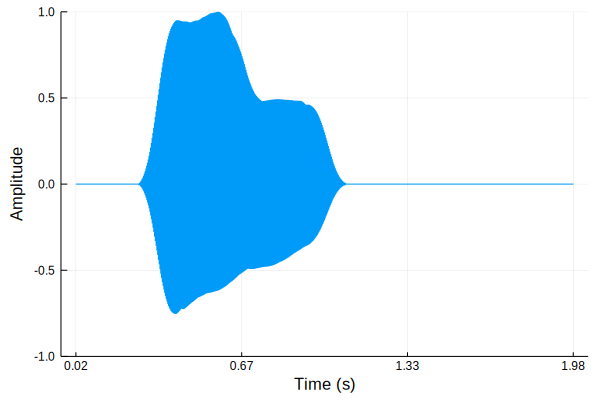

In [3]:
show_istft(S)

# Evolution in the contact space

We first lift the signal.

In [4]:
@time L = lift(S, threshold = 10, N=30) ;

size(L)

  1.830935 seconds (4.54 M allocations: 794.881 MiB, 5.72% gc time)


(251, 631, 30)

We then evolve it, according to the following Wilson-Cowan equation with delay:
$$
    \partial_\tau a(\tau, \omega, \nu) = -\alpha a(\tau,\omega,\nu)+\beta L(\tau,\omega,\nu) +\gamma\int_{\mathbb R^2} w(\omega,\nu\|\omega',\nu') \sigma(a(\tau-\delta, \omega', \nu')) \,d\omega'\,d\nu'
$$

WC evolution...100%|███████████████████████████████████▉|  ETA: 0:00:00

 10.489747 seconds (1.49 M allocations: 1.307 GiB, 0.47% gc time)


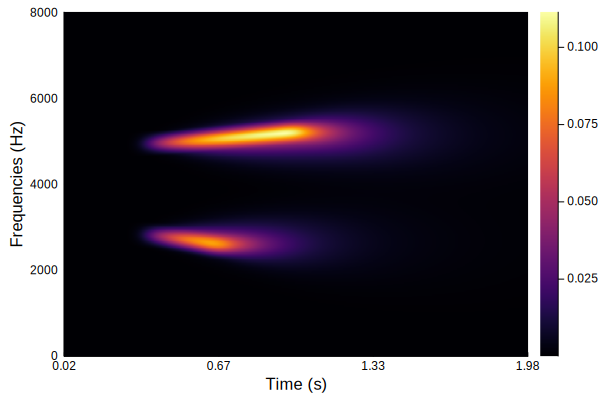

In [7]:
# dry run for compilation purposes
wc_delay(L, 0., 0., 0.)

α = 16
β = 1
γ = 18

@time W = wc_delay(L, α, β, γ, b = 4)

show_stft(W)

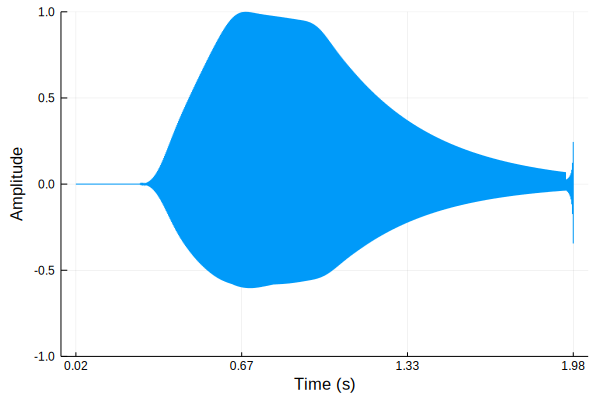

In [6]:
show_istft(W)